# Exploring coffee data
By E. Hobert (i6112127) and E. Risbakk (i6146197)

dataset: https://github.com/jldbc/coffee-quality-database/tree/master

Original database: https://database.coffeeinstitute.org/

## Import and cleanup

In [1]:
# Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

import cartopy
import cartopy.crs as crss
import cartopy.feature as cfeat
import cartopy.io.shapereader as shpreader

sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset
df = pd.read_csv("coffee-quality-database-master/data/arabica_data_cleaned.csv").drop("Unnamed: 0", axis=1)
df_robusta = pd.read_csv("coffee-quality-database-master/data/robusta_data_cleaned.csv").drop("Unnamed: 0", axis=1)
df = df.append(df_robusta, sort=False, ignore_index=True)

In [3]:
# Look at first entries
df.head()

,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,Altitude,Region,...,Category.Two.Defects,Expiration,Certification.Body,Certification.Address,Certification.Contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters,Mouthfeel
0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,0,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,NaN
1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,1,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,NaN
2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,NaN,...,0,"May 31st, 2011",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0,NaN
3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,oromia,...,2,"March 25th, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0,NaN
4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,guji-hambela,...,2,"April 3rd, 2016",METAD Agricultural Development plc,309fcf77415a3661ae83e027f7e5f05dad786e44,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,NaN


In [4]:
# removing unneeded columns and renaming them to be more consistent
df = df.drop(['Altitude', 'Lot.Number', 'Number.of.Bags', 'Bag.Weight', 
              'Owner', 'Certification.Address', 'Certification.Contact'], axis=1)
df = df.rename({'Owner.1': 'Owner'}, axis=1)

# rename all columns to snake_case
df = df.rename({
    name: name.lower().replace('.', '_') for name in df.columns.values.tolist()
}, axis='columns')

# Convert all height values to meters for consistency
def convertToMeters(x):
    if x['unit_of_measurement'] == "ft":
        x['altitude_low_meters'] *= 0.3048
        x['altitude_high_meters'] *= 0.3048
        x['altitude_mean_meters'] *= 0.3048
    return x
    
df = df.apply(convertToMeters, axis=1).drop(['unit_of_measurement'], axis=1)

In [5]:
# Look at descriptions
print(df.info())
print("\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 36 columns):
species                 1339 non-null object
country_of_origin       1338 non-null object
farm_name               980 non-null object
mill                    1021 non-null object
ico_number              1182 non-null object
company                 1130 non-null object
region                  1280 non-null object
producer                1107 non-null object
in_country_partner      1339 non-null object
harvest_year            1292 non-null object
grading_date            1339 non-null object
owner                   1332 non-null object
variety                 1113 non-null object
processing_method       1169 non-null object
aroma                   1339 non-null float64
flavor                  1339 non-null float64
aftertaste              1339 non-null float64
acidity                 1339 non-null float64
body                    1311 non-null float64
balance                 1339 non-n

In [6]:
df.head(10)

,species,country_of_origin,farm_name,mill,ico_number,company,region,producer,in_country_partner,harvest_year,...,category_one_defects,quakers,color,category_two_defects,expiration,certification_body,altitude_low_meters,altitude_high_meters,altitude_mean_meters,mouthfeel
0,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,0,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0,NaN
1,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,1,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0,NaN
2,Arabica,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,NaN,Specialty Coffee Association,NaN,...,0,0.0,NaN,0,"May 31st, 2011",Specialty Coffee Association,1600.0,1800.0,1700.0,NaN
3,Arabica,Ethiopia,yidnekachew dabessa coffee plantation,wolensu,NaN,yidnekachew debessa coffee plantation,oromia,Yidnekachew Dabessa Coffee Plantation,METAD Agricultural Development plc,2014,...,0,0.0,Green,2,"March 25th, 2016",METAD Agricultural Development plc,1800.0,2200.0,2000.0,NaN
4,Arabica,Ethiopia,metad plc,metad plc,2014/2015,metad agricultural developmet plc,guji-hambela,METAD PLC,METAD Agricultural Development plc,2014,...,0,0.0,Green,2,"April 3rd, 2016",METAD Agricultural Development plc,1950.0,2200.0,2075.0,NaN
5,Arabica,Brazil,NaN,NaN,NaN,NaN,NaN,NaN,Specialty Coffee Institute of Asia,2013,...,0,0.0,Bluish-Green,1,"September 3rd, 2014",Specialty Coffee Institute of Asia,NaN,NaN,NaN,NaN
6,Arabica,Peru,NaN,hvc,NaN,richmond investment-coffee department,NaN,HVC,Specialty Coffee Institute of Asia,2012,...,0,0.0,Bluish-Green,0,"September 17th, 2013",Specialty Coffee Institute of Asia,NaN,NaN,NaN,NaN
7,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromia,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,1570.0,1700.0,1635.0,NaN
8,Arabica,Ethiopia,aolme,c.p.w.e,010/0338,NaN,oromiya,Bazen Agricultural & Industrial Dev't Plc,Ethiopia Commodity Exchange,March 2010,...,0,0.0,NaN,0,"September 2nd, 2011",Ethiopia Commodity Exchange,1570.0,1700.0,1635.0,NaN
9,Arabica,Ethiopia,tulla coffee farm,tulla coffee farm,2014/15,diamond enterprise plc,"snnp/kaffa zone,gimbowereda",Diamond Enterprise Plc,METAD Agricultural Development plc,2014,...,0,0.0,Green,4,"March 29th, 2016",METAD Agricultural Development plc,1795.0,1850.0,1822.5,NaN


## Some quick initial visualisations for exploration

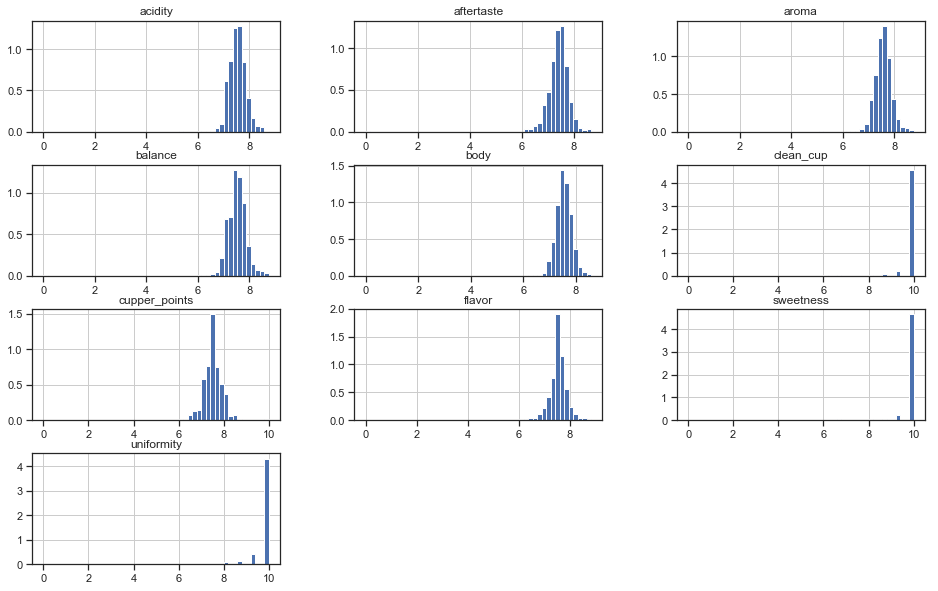

In [7]:
score_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points']
ax = df[df.species == 'Arabica'].hist(column=score_cols, bins=50, figsize=(16,10), sharey=False, normed=True)

### Final clean-up, and importing dataset for world countries

In [8]:
df_countries = pd.read_csv('countries.csv', index_col='ISO_CODE')
df_countries.head()

# Replace country names so they match with ADM0_A3.
df.country_of_origin = df.country_of_origin.replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'Cote d?Ivoire': 'Cote d\'Ivoire',
    'United States (Puerto Rico)': 'United States of America',
    'United States (Hawaii)': 'United States of America',
    'United States': 'United States of America',
})

# Confirm all countries in coffee dataset exist within full country dataset.
coffee_countries = df.country_of_origin.values
all_countries = df_countries['COUNTRY_NAME'].values

wrong_name = set([c for c in coffee_countries if c not in all_countries])

print("\n\n", wrong_name)
# Apparently there is an entry with no country.



 {nan}


# Visualizing Data
## Colourising countries on map

In [9]:
# Setting colours to countries.
# Using https://matthewkudija.com/blog/2018/05/25/country-maps/
# as reference.

def plot_countries(df, column, projection, title, edgecolor):
    # Basic map shared for 
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection=projection)
    ax.add_feature(cartopy.feature.OCEAN, facecolor='white')
    ax.outline_patch.set_edgecolor(edgecolor)
    
    # Loading in data for country borders
    shpfilename = shpreader.natural_earth(
        resolution='110m',
        category='cultural',
        name='admin_0_countries')
    
    # Read data from natural_earth.
    reader = shpreader.Reader(shpfilename)
    # Get countries.
    countries = reader.records()
    # Get values from the dataframe.
    values = list(df[column].unique())
    
    for country in countries:
        # See https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
        attribute = 'ADM0_A3'
        ADM0_A3 = country.attributes['ADM0_A3']
        
        # Get classification
        try:
            # .loc[country.attributes[attribute]] should give the df of countries
            # according to ADMO_A3.
            classification = df.loc[country.attributes[attribute]][column]
        except:
            pass
        
        # Plot country geometries onto map
#                           facecolor=(colors[values.index(classification)]),
        ax.add_geometries(country.geometry, crss.PlateCarree(),
                          facecolor=classification,
                          label=country.attributes[attribute],
                          edgecolor='#FFFFFF',
                          linewidth=0.25)
    
    plt.title(title, fontsize=18)

    title = 'maps/'+title+'.png'
    # plt.savefig(title, bbox_inches='tight', pad_inches=.2, dpi=300)
    # print('Saved: {}'.format(title))
    return ax

Map: 


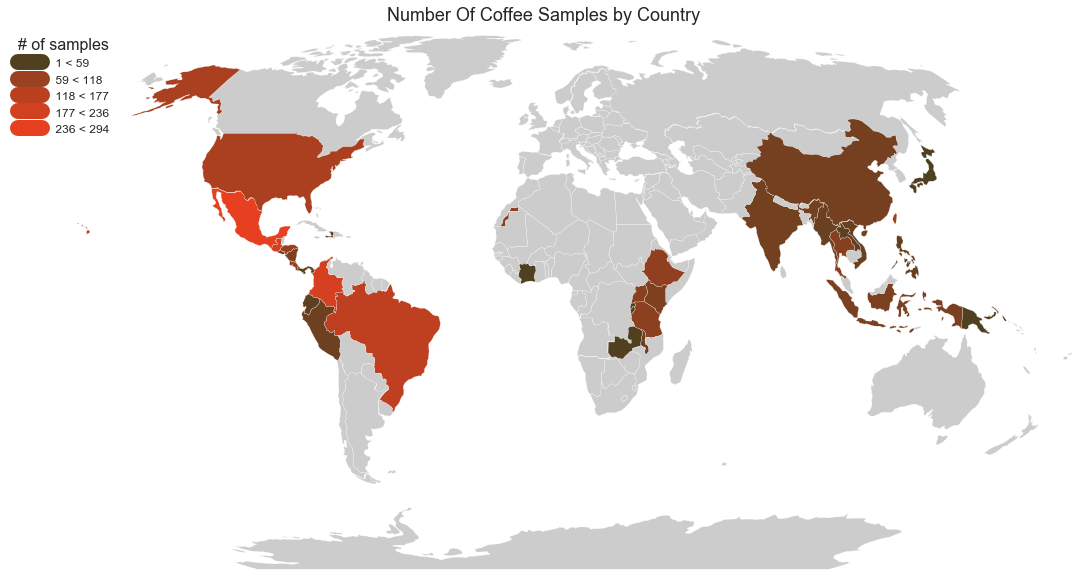

In [10]:
# Number of coffee samples per country.
# g.axes[0].legend()
projection = crss.Robinson()
colors = ['#ff2222', '#550055']
title='Number Of Coffee Samples by Country'

df_countries = df_countries.copy()

counts = df.country_of_origin.value_counts().to_dict()
min_count = min(counts.values())
max_count = max(counts.values())

def pct_to_color(pct):
    pct = max(0, min(pct**0.5 * 150 + 80, 255))
    return f"#{'{:02X}'.format(int(pct))}4020"
    
def color(name):
    if not name in df.country_of_origin.values:
        return "#cccccc"
    
    pct = (counts[name] - min_count) / (max_count - min_count)
    return pct_to_color(pct)

df_countries['color'] = df_countries['COUNTRY_NAME'].apply(color)

ax = plot_countries(df_countries, 'color', projection, title, edgecolor='white')

n = 5
to_count = lambda pct: int(pct * (max_count - min_count) + min_count)
labels = [f' {to_count(i/(n-1))} < {to_count((i+1)/(n-1))}' for i in range(n)]
custom_lines = [matplotlib.lines.Line2D([0], [0], color=pct_to_color(c/(n-1)), lw=16) for c in range(n)]

legend = ax.legend(custom_lines, labels, loc='upper left', fontsize=12, title='# of samples', frameon=False)
plt.setp(legend.get_title(),fontsize='16')
print("Map: ")

## Quick barplot for the number of samples per country
(used image editing software to overlay this on the map for the video)

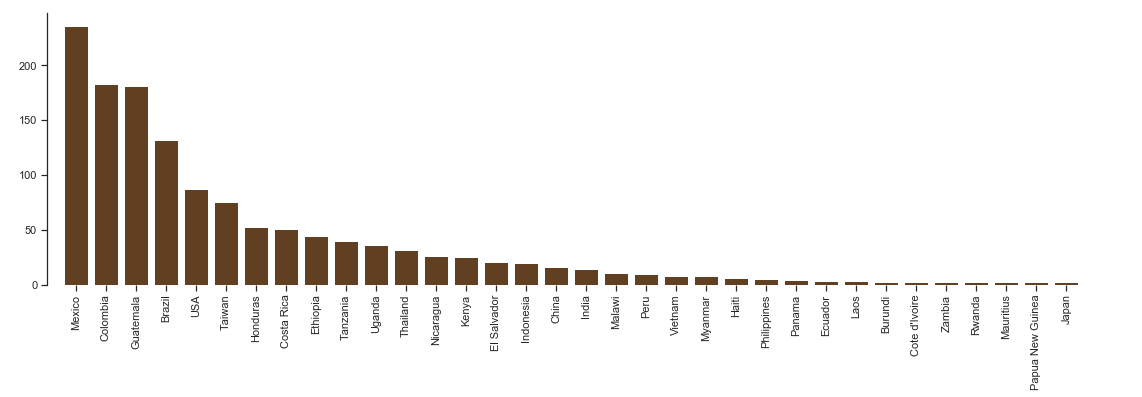

In [11]:
# Bar graph of number of coffee samples per country, top 50
# counts_top50 = dict(list(counts.items())[int(len(counts)/2):])
# plt.figure(figsize=(20,10))
# plt.bar(range(len(counts)), list(counts.values()), align='center')
# plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
# plt.title("Number of Coffee Samples by Country", fontsize='18')

# and alternative plot for overlaying on the map
plt.figure(figsize=(20,5))
plt.bar(range(len(counts)), [max(2, c) for c in list(counts.values())], align='center', color='#604020')

plt.xticks(range(len(counts)), [('USA' if n == "United States of America" else n) for n in counts.keys()], rotation=90);
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_position(('axes', 0.03))

In [12]:
# Top 5 make out how many percent of reviews total?
total0 = df.loc[df['country_of_origin'] == "Mexico"]['country_of_origin'].size
total1 = df.loc[df['country_of_origin'] == "Colombia"]['country_of_origin'].size
total2 = df.loc[df['country_of_origin'] == "Guatemala"]['country_of_origin'].size
total3 = df.loc[df['country_of_origin'] == "Brazil"]['country_of_origin'].size
total4 = df.loc[df['country_of_origin'] == "United States of America"]['country_of_origin'].size
print(total0, total1, total2, total3, total4)
total = total0 + total1 + total2 + total3 + total4
print("Total reviews in top 5 countries: ", total)
full_total = df['country_of_origin'].size
print("Percentage: ", (total/full_total))

236 183 181 132 87
Total reviews in top 5 countries:  819
Percentage:  0.6116504854368932


# Flavor Profile of Different Countries
First, investigating the top 5 country flavor profiles.

In [13]:
# Let us investigate the top 5 countries. # Have list of attributes to test below.
score_cols = ['aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points']
def show_flavor_profile(country_name):
    return df[df.country_of_origin == country_name].hist(column=score_cols, bins=50, figsize=(16,10), sharey=False, normed=True)
    

## Individual Flavor Profiles

### Mexico

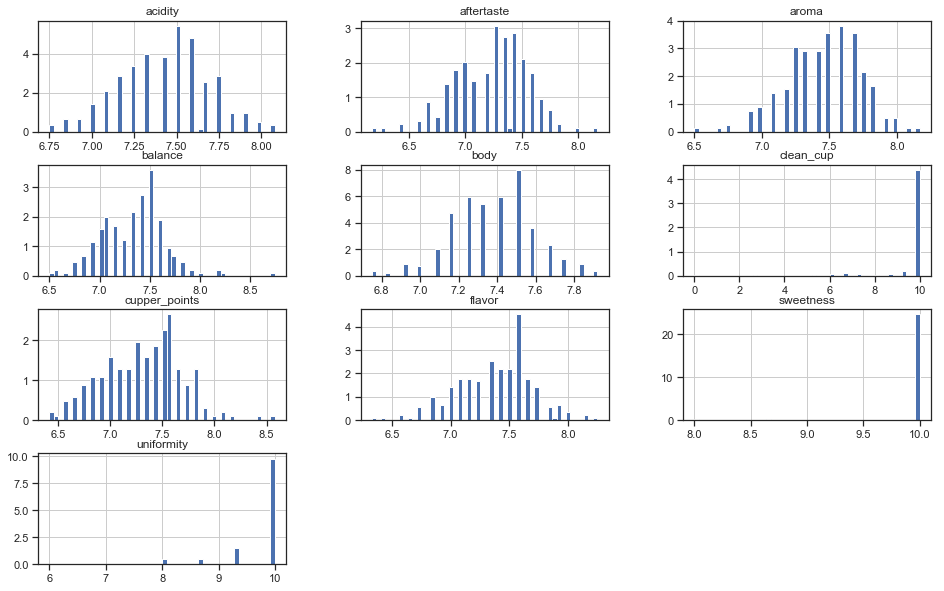

In [14]:
show_flavor_profile("Mexico");

### Colombia

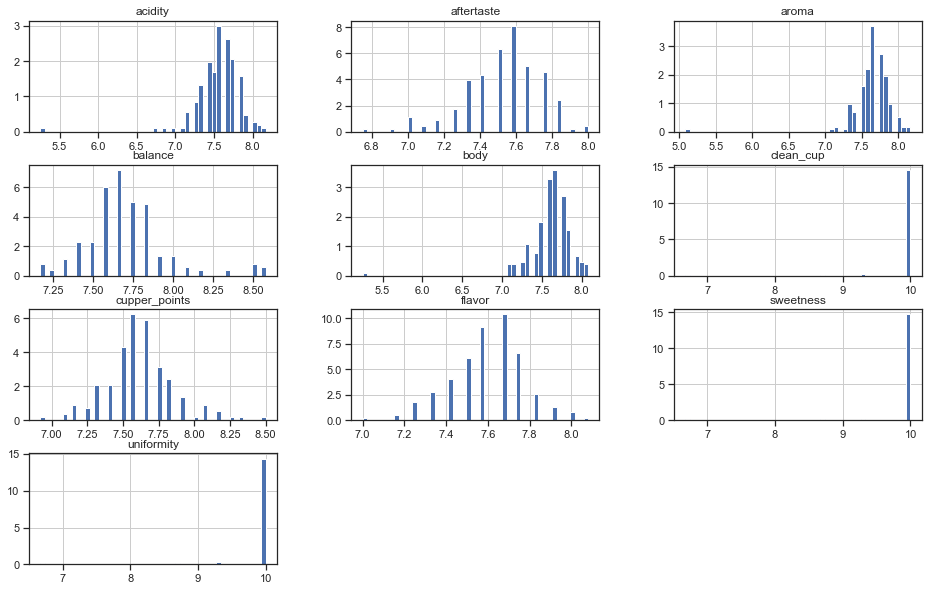

In [15]:
show_flavor_profile("Colombia");

### Guatemala

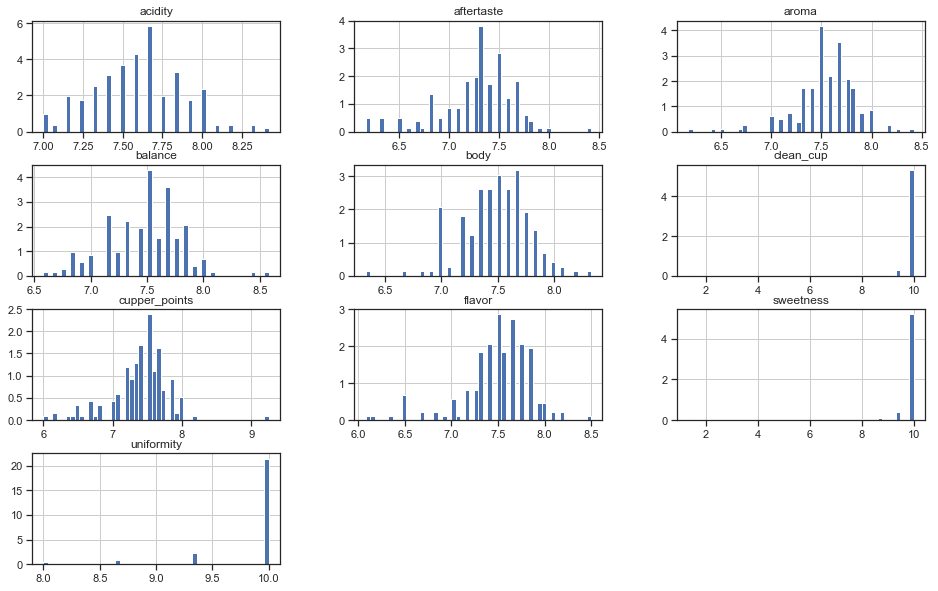

In [16]:
show_flavor_profile("Guatemala");

### Brazil

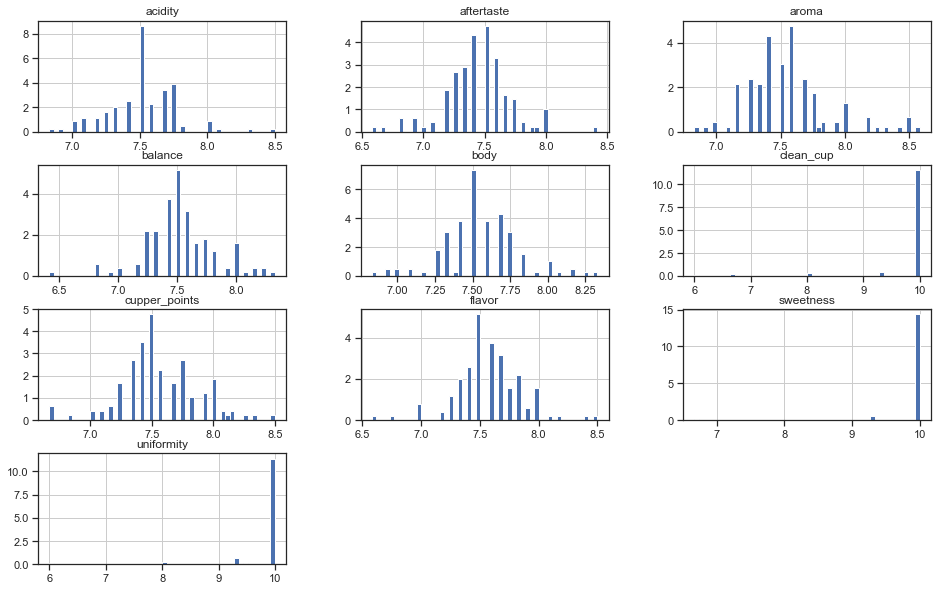

In [17]:
show_flavor_profile("Brazil");

### United States of America

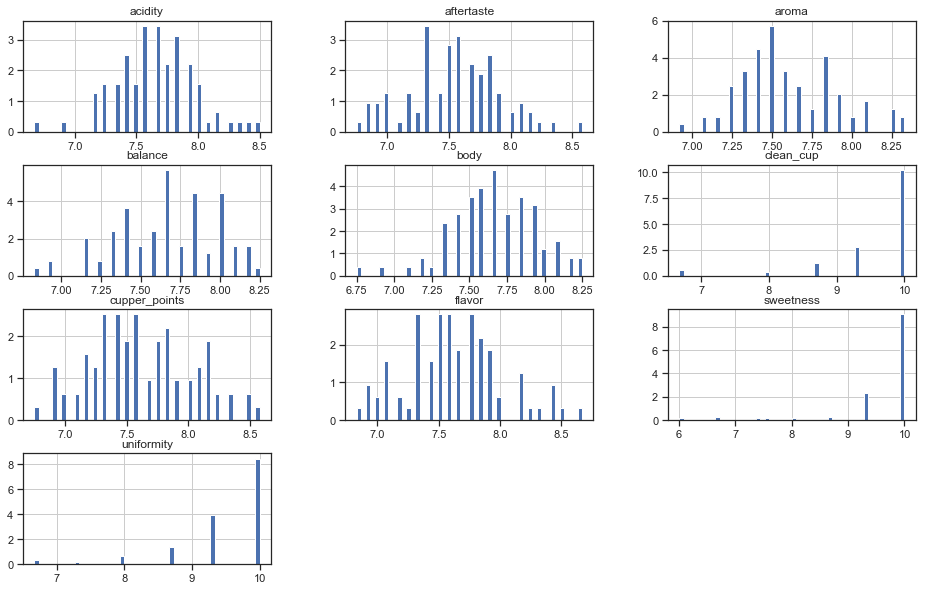

In [18]:
show_flavor_profile("United States of America");

## Comparing the Countries

In [19]:
# Plot overlapping distributions of some different categories.
# Maybe acidity, aftertaste, and balance?
# Only three countries, bc otherwise it gets a lot messier.

def plot_distrib(df_data, attrib, country_list):
    plt.figure(figsize=(15,7))
    for i, country in enumerate(country_list):
        sns.kdeplot(df_data[df_data.country_of_origin == country][attrib], shade=True, label=country)
    plt.title(f"Score Comparison: {attrib[0].upper()}{attrib[1:]}", fontsize=18)
    plt.xlabel(attrib)

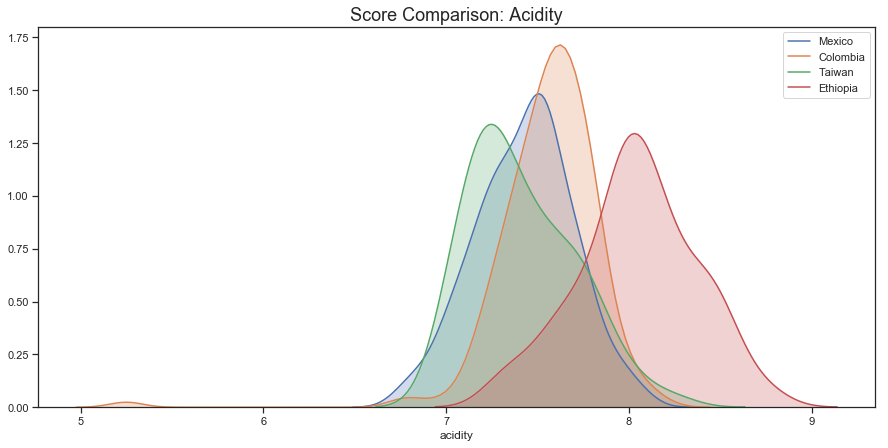

In [20]:
# Acidity
plot_distrib(df, "acidity", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

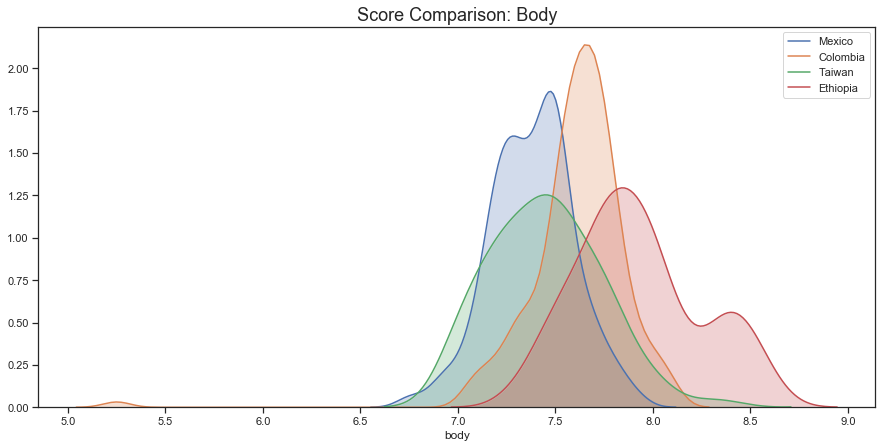

In [21]:
# Body
plot_distrib(df, "body", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

In [22]:
# plot_distrib(df, "aftertaste", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

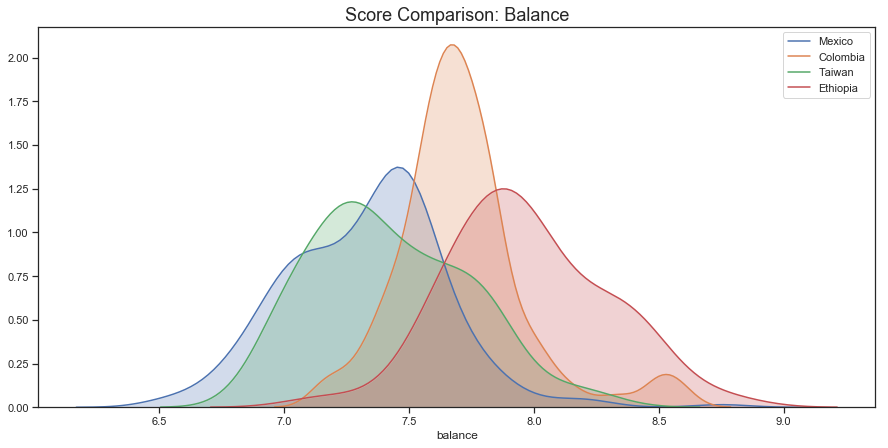

In [23]:
plot_distrib(df, "balance", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

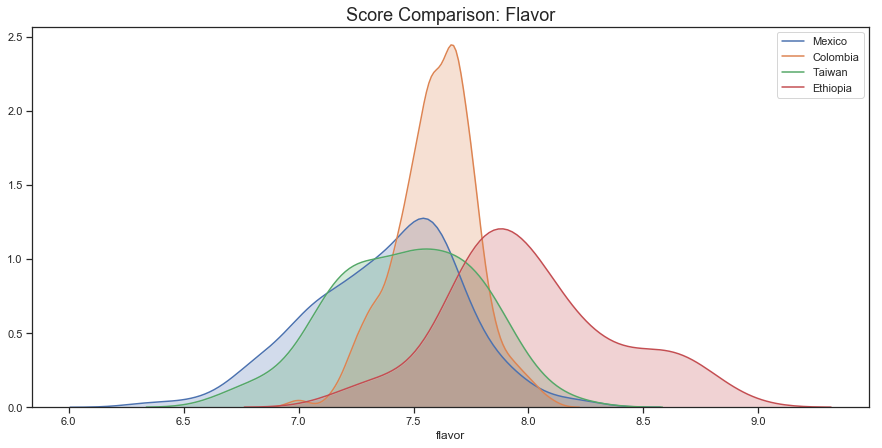

In [24]:
plot_distrib(df, "flavor", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

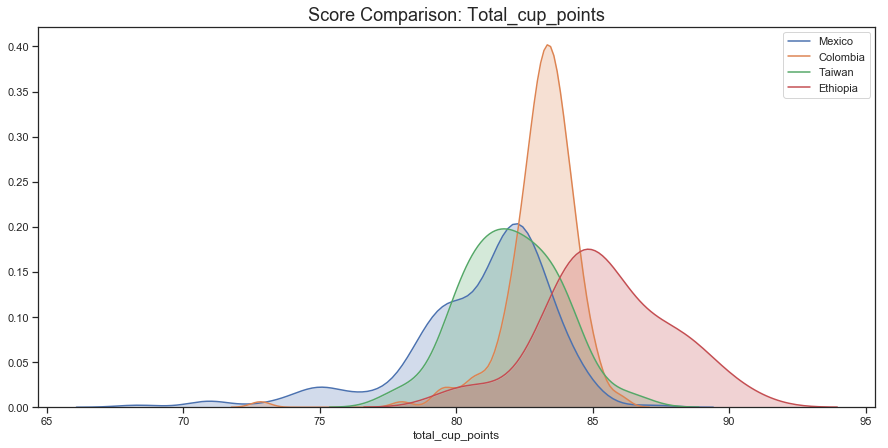

In [25]:
plot_distrib(df, "total_cup_points", ["Mexico", "Colombia", "Taiwan", "Ethiopia"])

# How does altitude affect the taste?

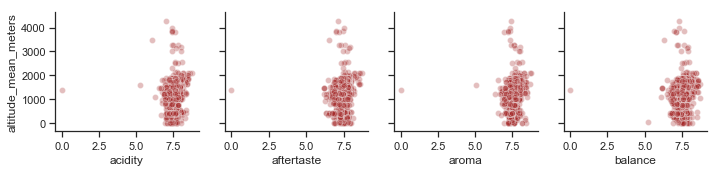

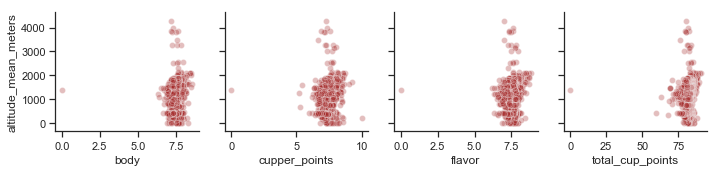

In [26]:
# plt.figure(figsize=(15,7))
sns.pairplot(df.drop(df.loc[df.altitude_mean_meters > 8000].index), plot_kws={'alpha': 0.3, 'color':'brown'},
    y_vars=["altitude_mean_meters"], x_vars=["acidity", "aftertaste", "aroma", "balance"]);
sns.pairplot(df.drop(df.loc[df.altitude_mean_meters > 8000].index), plot_kws={'alpha': 0.3, 'color':'brown'},
    y_vars=["altitude_mean_meters"], x_vars=["body", "cupper_points", "flavor", 'total_cup_points']);

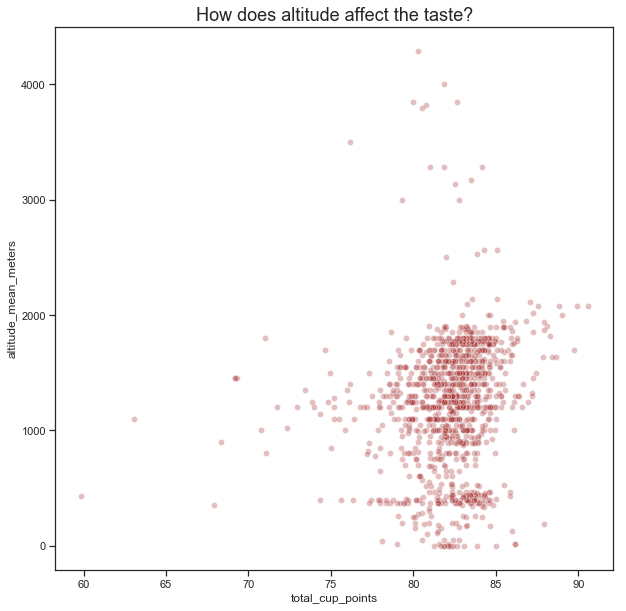

In [27]:
plt.figure(figsize=(10,10))
data = df.drop(df.loc[df.altitude_mean_meters > 8000].index).drop(df.loc[df.total_cup_points < 1].index)
sns.scatterplot(x=data['total_cup_points'], y=data['altitude_mean_meters'], alpha=0.3, color='brown')
plt.title('How does altitude affect the taste?', fontsize=18);

## (Discarded attempt at making animated graphs)

In [28]:
def get_height_jointplot(df, attrib_1, attrib_2, min_height, max_height):
    df_data = df.drop(df.loc[df.altitude_mean_meters > max_height].index)
    df_data = df_data.drop(df.loc[df.altitude_mean_meters < min_height].index)
    print("Number of datapoints: ", df_data[attrib_1].size)
    return sns.jointplot(x=attrib_1, y=attrib_2, data=df_data, kind="kde");

In [29]:
# Animation reference from https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1
#fig = plt.figure(figsize=(10,6))

#writer = animation.FFMpegWriter(fps=10)

#with writer.saving(fig, "writer_test.mp4", 100):
#    for i in range(100):
#        df_data = df.drop(df.loc[df.altitude_mean_meters > 500+(10*i)].index)
#        df_data = df_data.drop(df.loc[df.altitude_mean_meters < (10*i)].index)
#        sns.jointplot(x="body", y="flavor", data=df_data, kind="kde");
#        writer.grab_frame()

# How does Robusta coffee compare to Arabica coffee?

In [30]:
def plot_arabica_robusta(df_data, attrib):
    plt.figure(figsize=(15,7))
#     for i, country in enumerate(country_list):
    sns.kdeplot(df[df.species == 'Arabica'][attrib], shade=True, label='Arabica')
    sns.kdeplot(df[df.species == 'Robusta'][attrib], shade=True, label='Robusta')
    
    plt.title(f"Arabica vs Robusta: {attrib[0].upper()}{attrib[1:]}", fontsize=18)
    plt.xlabel(f'{attrib} score')

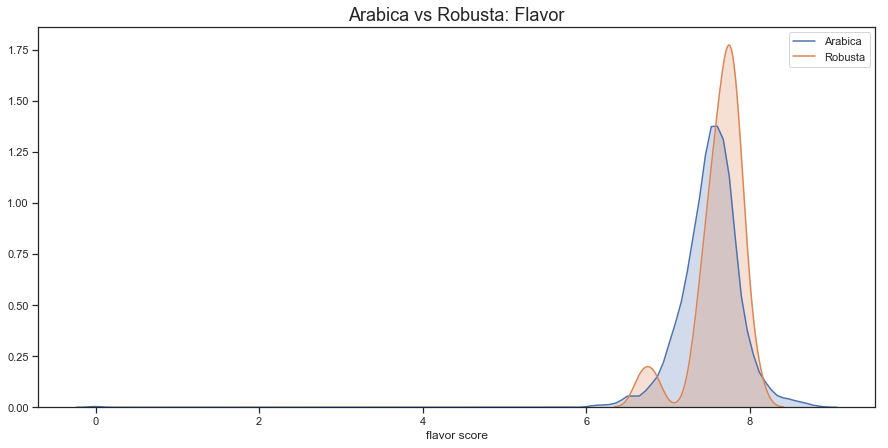

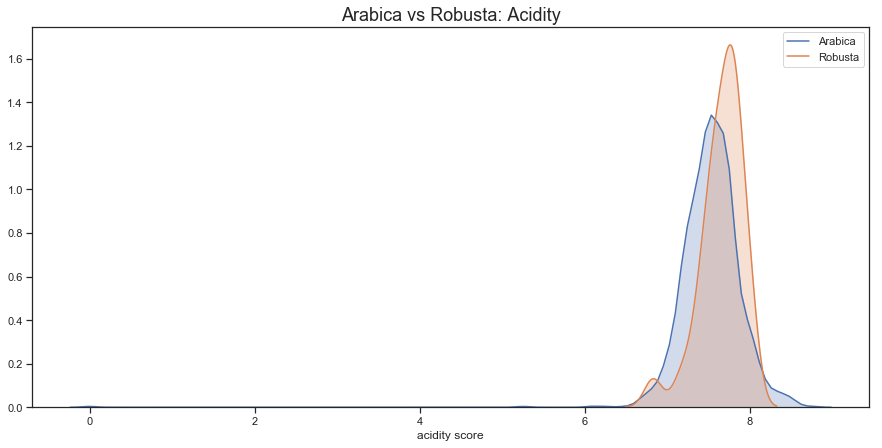

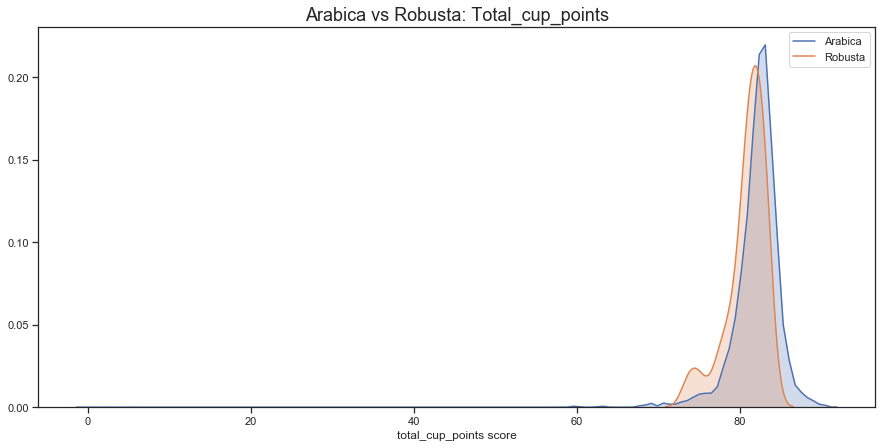

In [31]:
# plot_arabica_robusta(df, 'aftertaste')
plot_arabica_robusta(df, 'flavor')
# plot_arabica_robusta(df, 'aroma')
plot_arabica_robusta(df, 'acidity')
# plot_arabica_robusta(df, 'sweetness')
# plot_arabica_robusta(df, 'balance')
plot_arabica_robusta(df, 'total_cup_points')